# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

### Set Variables and Paths

In [2]:
# Set Variables
fieldstrength = '3T'
atlas = 'S100'
bblids = []
sesids = []
nmaps = ["mGluR5", "NMDA","GABA"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)


### Create functions

In [3]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [4]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)
print(heat_df)

        Unnamed: 0  NZMean_52  NZMean_54  NZMean_55  NZMean_56  NZMean_60  \
BBLID                                                                       
20303            0   9.650059   9.001519   8.006914   9.796985   8.466033   
90217            1  10.815921  10.755164   9.616452  11.162351   7.832265   
88608            2  12.541982   9.086602   9.983268   8.763650   7.963346   
21874            3   8.073702   8.707873   8.709772   7.862241   6.789480   
94288            4  10.614138   9.798343  10.625427  11.216247   8.068989   
...            ...        ...        ...        ...        ...        ...   
135085          81   8.250659   8.214067   6.562370   8.050416   6.721325   
135277          82   9.320137   8.138041   6.827108   8.221849   6.184430   
117397          83        NaN        NaN        NaN        NaN        NaN   
87646           84        NaN        NaN        NaN        NaN        NaN   
93242           85  15.962514  10.434978  10.168327  11.848210   8.484855   

### Correlation matrix after masking out the significant ones

In [6]:
corr_df=heat_df.corr()
#pvals = corr_sig(heat_df)
#mask01 = np.invert(np.tril(pvals<0.01))
#mask001 = np.invert(np.tril(pvals<0.001))

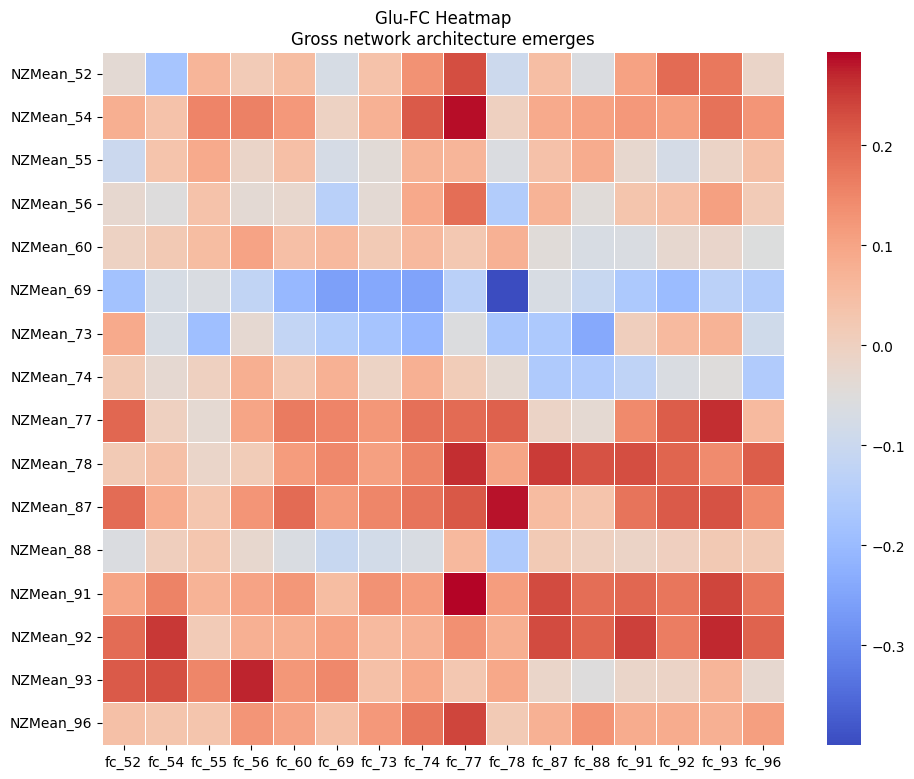

In [7]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

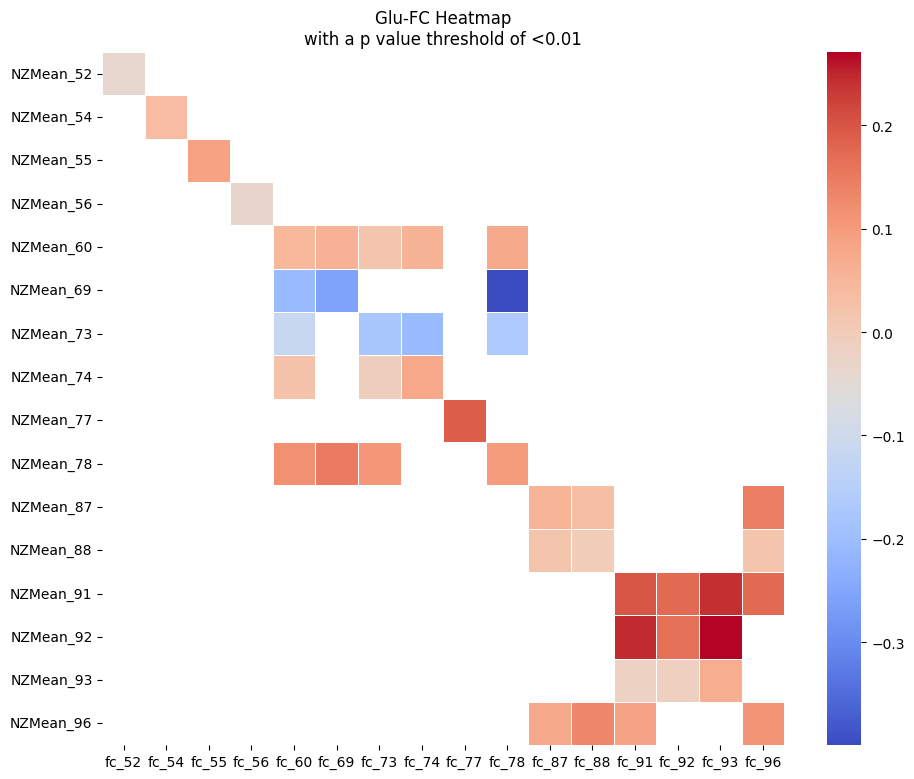

In [9]:
# Keep only signficant values
cestfc = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
pvals = corr_sig(cestfc)
pvals
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.00001)


plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.01')
plt.show()

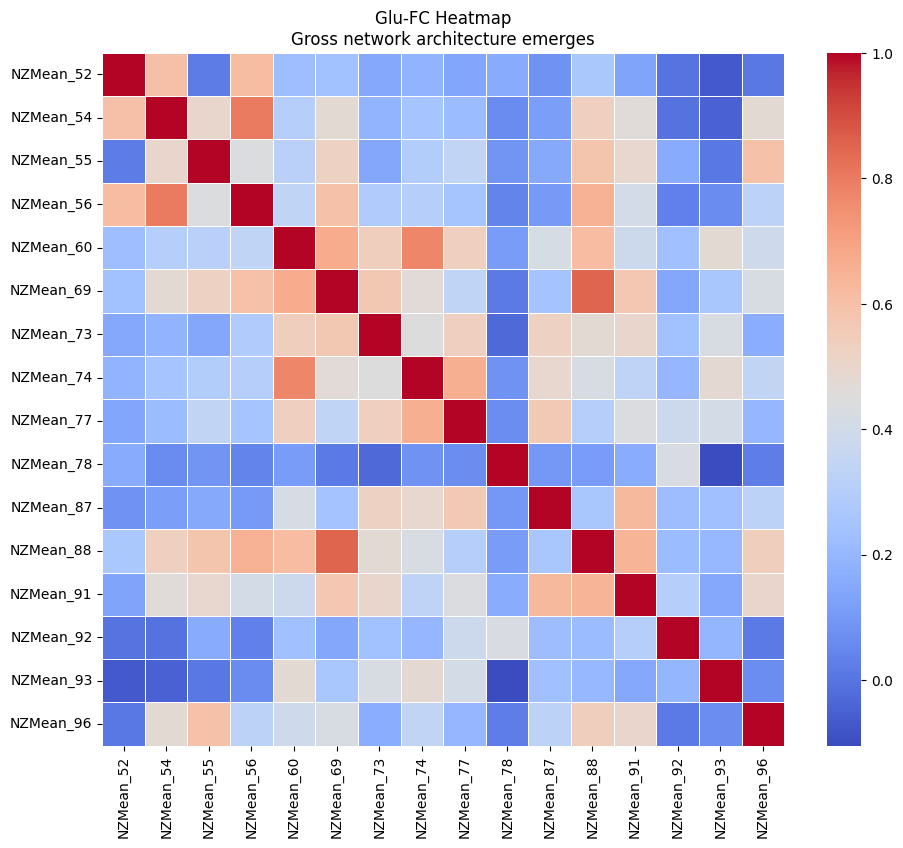

In [10]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

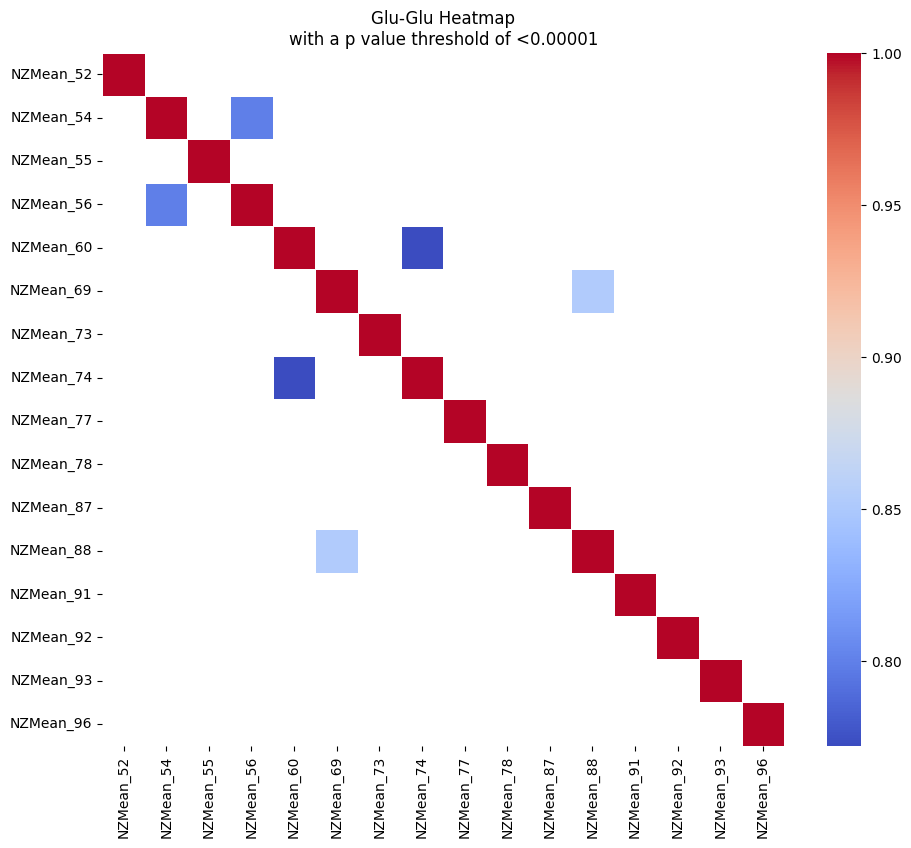

In [12]:
# Keep only signficant values
pvals = corr_sig(cestcorr_df) #

#cestpvals = cestcorr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.0001)

plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-Glu Heatmap\nwith a p value threshold of <0.00001')
plt.show()

In [ ]:
### Within- vs between-network

In [13]:
def within_between(corr_df, parcels,symmetric):
    # Returns average correlation within and between network.
    ins = []
    outs = []
    for row in corr_df.index:
        for col in corr_df.columns:
            # Within-network: row and column have to contain parcel names
            if any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    ins.append(corr_df.loc[row, col])
                    
            # Between-network: Only row contains parcel name
            elif any(parcel in row for parcel in parcels) and not any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    outs.append(corr_df.loc[row, col])
            if symmetric == False: # Only run columns with parcel name if corr_df is asymmetric
                if not any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                    if not pd.isna(corr_df.loc[row, col]):
                        outs.append(corr_df.loc[row, col])
    # Run t test comparing within- vs between-network values
    t, p = sp.stats.ttest_ind(ins,outs)
    # Take avg.
    avgin = np.mean(ins)
    sdin = np.std(ins)
    avgout = np.mean(outs)
    sdout = np.std(outs)
    return (avgin, sdin, avgout, sdout, t,p) 

vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

In [14]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(cestcorr_df, vis, True),
    within_between(cestcorr_df, mn, True),
    within_between(cestcorr_df, da, True),
    within_between(cestcorr_df, sn, True),
    within_between(cestcorr_df, lim, True),
    within_between(cestcorr_df, ecn, True),
    within_between(cestcorr_df, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

/Users/pecsok/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pecsok/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/pecsok/.local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/pecsok/.local/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/pecsok/.local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Within_sd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Between_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Between_sd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
t,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(masked_cestcorr, vis, True),
    within_between(masked_cestcorr, mn, True),
    within_between(masked_cestcorr, da, True),
    within_between(masked_cestcorr, sn, True),
    within_between(masked_cestcorr, lim, True),
    within_between(masked_cestcorr, ecn, True),
    within_between(masked_cestcorr, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,5.397691e-01,6.063313e-01,6.922882e-01,5.318295e-01,8.448743e-01,4.467981e-01,4.415832e-01
Within_sd,1.950166e-01,1.928823e-01,1.840803e-01,2.697196e-01,2.193809e-01,3.215880e-01,3.178394e-01
Between_avg,2.040628e-01,2.778817e-01,4.088937e-01,3.039170e-01,-2.976418e-02,3.032648e-01,2.886800e-01
Between_sd,2.673076e-01,2.514458e-01,1.740765e-01,2.537667e-01,2.198574e-01,2.510581e-01,2.319945e-01
t,1.755684e+01,1.098268e+01,6.033539e+00,9.440447e+00,9.177059e+00,5.611092e+00,6.975389e+00
p,1.800659e-56,1.707155e-24,1.453889e-08,9.586148e-20,1.846099e-13,3.046691e-08,7.400873e-12


In [98]:
fcdf = pd.DataFrame(zip(
    within_between(cestfc, vis, True),
    within_between(cestfc, mn, True),
    within_between(cestfc, da, True),
    within_between(cestfc, sn, True),
    within_between(cestfc, lim, True),
    within_between(cestfc, ecn, True),
    within_between(cestfc, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
fcdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
fcdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,3.357875e-02,7.486184e-02,-0.177215,-0.031078,-0.044938,-0.033509,7.696920e-02
Within_sd,1.080365e-01,1.007346e-01,0.135831,0.133377,0.197829,0.123778,1.347199e-01
Between_avg,8.031083e-02,-3.531636e-03,-0.103724,-0.037992,0.042382,-0.011320,3.873417e-02
Between_sd,1.193191e-01,1.149599e-01,0.139306,0.130280,0.136657,0.120031,1.309165e-01
t,-6.498262e+00,7.169117e+00,-2.065325,0.946675,-2.447114,-3.001328,6.707202e+00
p,1.044012e-10,1.367758e-12,0.039526,0.343917,0.014823,0.002724,2.398810e-11


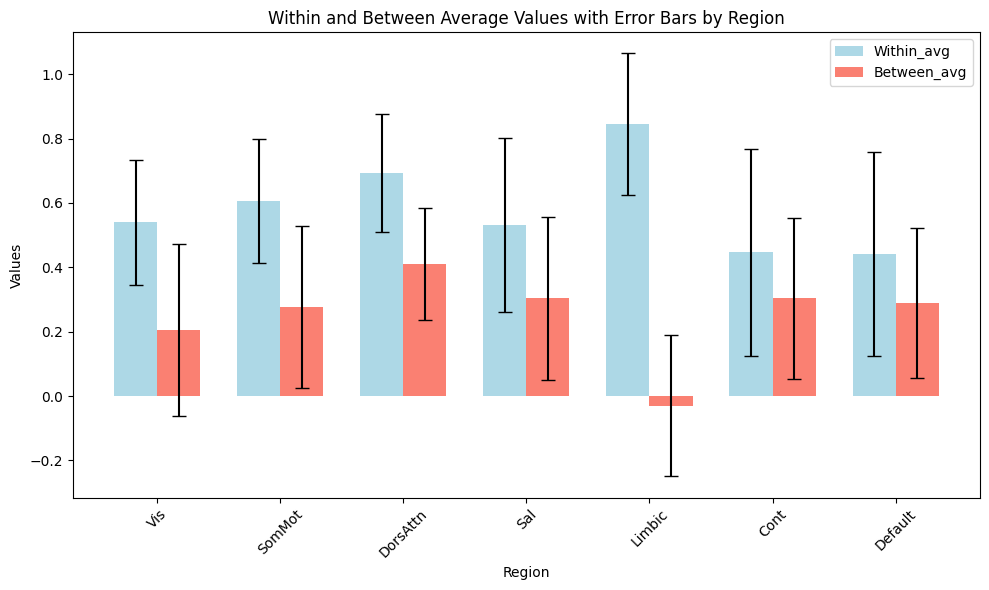

In [114]:
# Make a bar plot comparing within vs between values.
# Extract values
df = cestdf
regions = df.columns
within_avg = df.loc['Within_avg']
within_sd = df.loc['Within_sd']
between_avg = df.loc['Between_avg']
between_sd = df.loc['Between_sd']

# Set positions and width for bars
x = np.arange(len(regions))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot within and between averages with error bars
ax.bar(x - width/2, within_avg, width, yerr=within_sd, label='Within_avg', capsize=5, color='lightblue')
ax.bar(x + width/2, between_avg, width, yerr=between_sd, label='Between_avg', capsize=5,color='salmon')

# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Values')
ax.set_title('Within and Between Average Values with Error Bars by Region')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### NMAP correlations

In [41]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
#print(cestNZMeans)
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])

mGluR5
r=0.24299725644741313  p=0.013858505052586314
NMDA
r=0.022426387016186256  p=0.8229657832872606
GABA
r=0.5130095803165076  p=3.52877661447222e-08


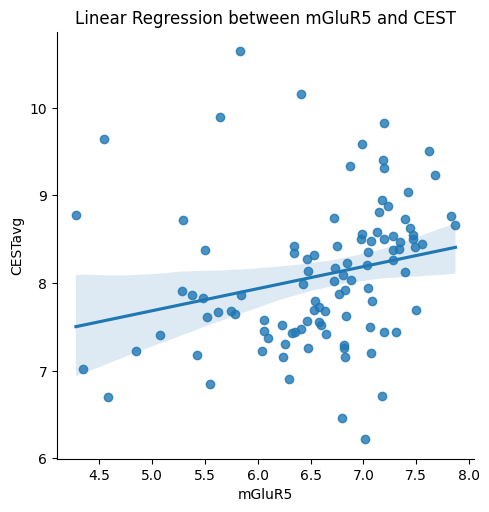

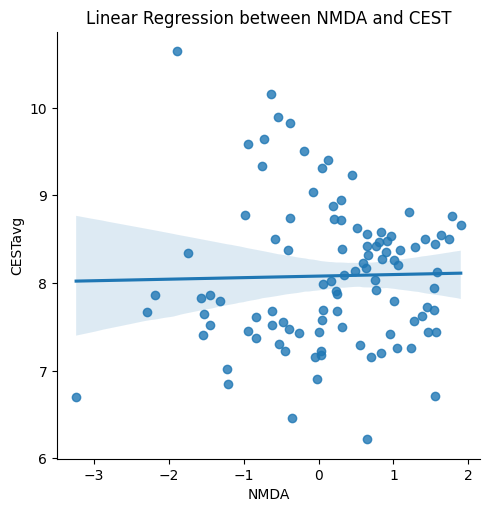

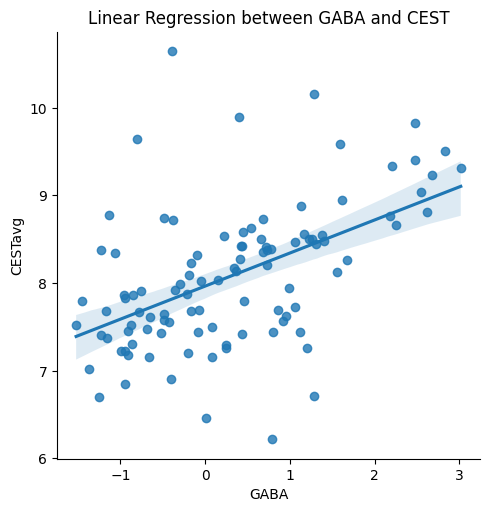

In [42]:
# Loop through nmaps and make correlation plots
# @Maggie, add color by SA axis value.
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(nmap)
    print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 


In [43]:
import statsmodels.api as sm

x=glunmaps[nmaps]
y=glunmaps["CESTavg"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                CESTavg   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     20.42
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           2.34e-10
Time:                        20:23:37   Log-Likelihood:                -98.849
No. Observations:                 102   AIC:                             205.7
Df Residuals:                      98   BIC:                             216.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8104      0.900      9.788      0.0

In [20]:
# @Maggie, this is a temporary chunk. Move this to the end of the pipeline_parcellated script.
columns = cestmat.columns[cestmat.notnull().sum() > len(cestmat)*.75]
parcels = [col.split('_')[1] for col in columns if '_' in col]

unique_list = list(set(parcels))
seen = set()
unique_list = [x for x in parcels if not 
               (x in seen or seen.add(x))]
parcels = unique_list
print(parcels)

['502', '504', '518', '521', '532', '540', '542', '544', '545', '552', '555', '558', '560', '561', '562', '563', '564', '567', '574', '580', '581', '587', '590', '595', '596', '598', '606', '608', '613', '692', '707', '709', '712', '750', '751', '752', '754', '757', '759', '761', '762', '763', '764', '765', '766', '767', '768', '792', '793', '794', '795', '796', '797', '807', '808', '809', '811', '812', '855', '856', '893', '894', '895', '897', '898', '900', '901', '902', '903', '904', '905', '906', '909', '910', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '944', '945', '946', '947', '956', '958', '959', '961', '973', '974']


In [ ]:
receptor_names = np.array(["NMDA","mGluR5","GABAa"])
np.save(path+'data/receptor_names_pet.npy', receptor_names)

# make final region x receptor matrix
receptor_data = np.zeros([nnodes, len(receptor_names)])


# NMDA Data
receptor_data[:, 0] = r[:, 0]


# plot each receptor map
if scale == 'scale1000_17':
    annot = datasets.fetch_schaefer2018('fsaverage')['1000Parcels17Networks']
    type(annot)
    print(annot)
    
    for k in range(len(receptor_names)):
        brain = plotting.plot_fsaverage(data=receptor_data[:, k],
                                        lhannot=annot.lh,
                                        rhannot=annot.rh,
                                        colormap='plasma',
                                        views=['lat', 'med'],
                                        data_kws={'representation': "wireframe"})
        brain.save_image(path+'figures/scale1000_17/surface_receptor_'+receptor_names[k]+'.png')